In [2]:
import os,pandas as pd, numpy as np, joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt, json

In [3]:
Data_dir="../data"
Out_Models="../models"
Out_Reports="../reports"
Out_Output="../output"

for d in [Out_Models, Out_Reports, Out_Output]:
    os.makedirs(d, exist_ok=True)

In [5]:
train_path= os.path.join(Data_dir, "train.csv")
test_path= os.path.join(Data_dir, "test.csv")
train=pd.read_csv(train_path)
test=pd.read_csv(test_path)

In [6]:
for df in (train,test):
    df["FamilySize"]= df["SibSp"].fillna(0) + df["Parch"].fillna(0) +1
    df["IsAlone"]=(df["FamilySize"]==1).astype(int)
    df["Pclass"]=df.Pclass.astype(str)

In [7]:
feature_cols=["Pclass","Sex","Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "IsAlone"]
num_cols=["Age", "SibSp", "Parch", "Fare", "FamilySize", "IsAlone"]
cat_cols=["Pclass", "Sex", "Embarked"]

In [10]:
X= train[feature_cols].copy()
y= train.Survived.copy()
X_test= test[feature_cols].copy()

for df in (X,X_test):
    for col in cat_cols:
        df[col]= df[col].astype(str)

In [11]:
X_train, X_val, y_train, y_val= train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [12]:
ohe=OneHotEncoder(handle_unknown="ignore", sparse_output=False)
numeric_tf= Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_tf= Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe",ohe)
])

preprocessor= ColumnTransformer(transformers=[
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

In [14]:
log_reg= LogisticRegression(max_iter=1000, solver= "lbfgs")
pipe= Pipeline([
    ("pre", preprocessor),
    ("model", log_reg)
])

pipe.fit(X_train,y_train)
preds= pipe.predict(X_val)

In [15]:
acc= accuracy_score(y_val,preds)
cm= confusion_matrix(y_val,preds)
cr= classification_report(y_val,preds,digits=3)

print(f"Validation Accuracy: {acc: .4f}")
print(cr)

Validation Accuracy:  0.8156
              precision    recall  f1-score   support

           0      0.818     0.900     0.857       110
           1      0.810     0.681     0.740        69

    accuracy                          0.816       179
   macro avg      0.814     0.791     0.799       179
weighted avg      0.815     0.816     0.812       179



In [17]:
json.dump({
    "Val_accuracy":float(acc)
}, open(f"{Out_Reports}/titanic_logreg_metrics.json","w"), indent=2)

joblib.dump(pipe, f"{Out_Models}/titanic_logreg.joblib")


['../models/titanic_logreg.joblib']


Logistic Regression baseline done and saved


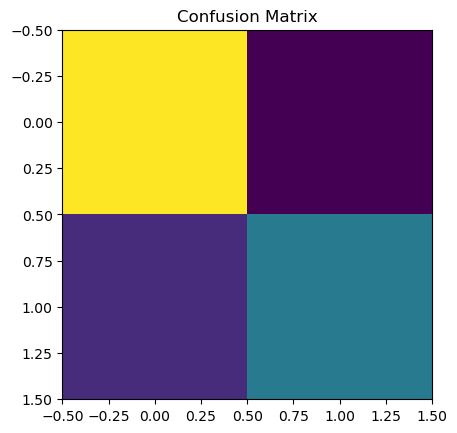

In [18]:
plt.imshow(cm);
plt.title("Confusion Matrix");
plt.savefig(f"{Out_Reports}/titanic_logreg_confmat.png")
print("\nLogistic Regression baseline done and saved")